# **Computational Learning and Deep Learning**

## PyTorch homework

In [63]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

The following code downloads the MNIST dataset and creates a PyTorch dataset with noisy images as inputs and original images as outputs.

In [64]:
mnist_train = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor())

In [65]:
class NoisyMNISTDataset(Dataset):
    def __init__(self, mnist_dataset, noise_factor=0.5):
        self.mnist_dataset = mnist_dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        # Get the original image and label from the MNIST dataset
        original_image, label = self.mnist_dataset[idx]

        # Add noise to the original image
        noisy_image = self.add_noise(original_image)

        return noisy_image, original_image

    def add_noise(self, image):
        # Convert the image to a NumPy array
        image_np = image.numpy()

        # Generate random noise with the same shape as the image
        noise = np.random.normal(loc=0, scale=self.noise_factor, size=image_np.shape)

        # Add the noise to the image
        noisy_image = image_np + noise

        # Clip the values to be between 0 and 1
        noisy_image = np.clip(noisy_image, 0, 1)

        # Convert the NumPy array back to a PyTorch tensor
        noisy_image = torch.from_numpy(noisy_image).float()

        return noisy_image

In [66]:
noisy_mnist_train = NoisyMNISTDataset(mnist_train, noise_factor=0.5)
noisy_mnist_test = NoisyMNISTDataset(mnist_test, noise_factor=0.5)

In [67]:
batch_size = 16

train_dataset = torch.utils.data.DataLoader(dataset=noisy_mnist_train, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.DataLoader(dataset=noisy_mnist_test, batch_size=batch_size, shuffle=False)

#### Exercise:

Define and train an autoencoder neural network using convolutional layers and without using fully connected layers. That is, use, at least once each, the following operations: convolution, max pooling, transposed convolutions.

Once the model is trained show the input and ouput of the model for some images in the test set, along with the original image.

In [68]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        ####################
        ## encoder layers ##
        ####################

        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, kernel_size = 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, kernel_size = 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        ####################
        ## decoder layers ##
        ####################
        
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x

# initialize the NN
#model = Autoencoder()
#print(model)

In [69]:
autoencoder = Autoencoder()

In [70]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [71]:
def train(model, train_dataset, optimizer, epoch):
    model.train()

    for step, (data, target) in enumerate(train_dataset):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        if step % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(data), len(train_dataset.dataset),
                100. * step / len(train_dataset), loss.item()))

In [76]:
def test(model, test_dataset):
    model.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataset:
            output = model(data)
            test_loss += loss_function(output, target).item() * target.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataset.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(
        test_loss, correct, len(test_dataset.dataset),
        100. * correct / len(test_dataset.dataset)))

In [77]:
num_epochs = 2

for epoch in range(1, num_epochs + 1):
    train(autoencoder, train_dataset, optimizer, epoch)
    test(autoencoder, test_dataset)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.034661
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.029794
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.033763
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.030369

Test set: Average loss: 0.0303

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.033621
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.024244
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.028240
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.028760

Test set: Average loss: 0.0296



Plot images at random

In [78]:
n_images = 3
idx_images = np.random.randint(len(noisy_mnist_test), size=n_images)

noisy_images = np.stack([noisy_mnist_test[i][0] for i in idx_images])
images = np.stack([noisy_mnist_test[i][1] for i in idx_images])

noisy_images = noisy_images.reshape(n_images, 1, 28, 28)

noisy_images_tensor = torch.tensor(noisy_images, dtype=torch.float32)

output = autoencoder(noisy_images_tensor)

output = output.detach().numpy()

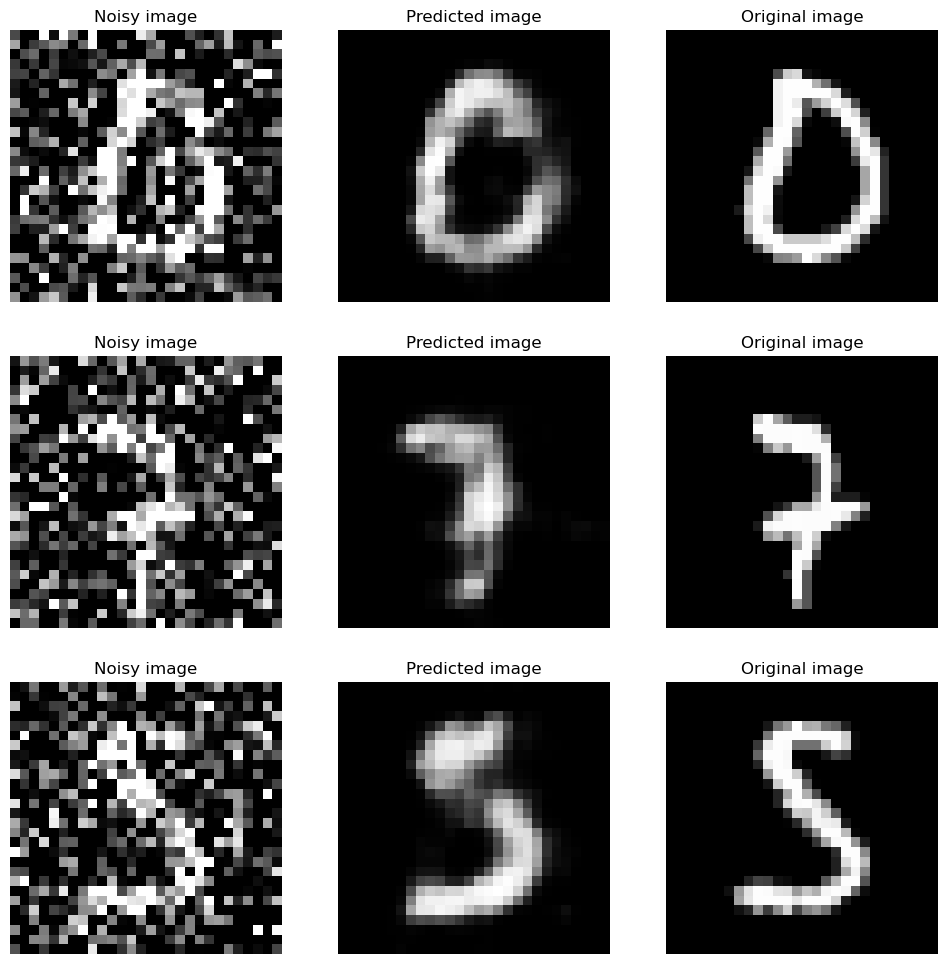

In [79]:
ncols = 3
nrows = n_images

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[4*ncols, 4*nrows])

for i, n in enumerate(idx_images):
    ax[i,0].imshow(noisy_images[i].reshape(28,28), cmap="gray")
    ax[i,0].set_title("Noisy image")
    ax[i,0].axis("off")

    ax[i,1].imshow(output[i].reshape(28,28), cmap="gray")
    ax[i,1].set_title("Predicted image")
    ax[i,1].axis("off")

    ax[i,2].imshow(images[i].reshape(28,28), cmap="gray")
    ax[i,2].set_title("Original image")
    ax[i,2].axis("off")